# Análisis de las imágenes

## Carga del Dataset
Vamos a definir una clase, que tome como base la clase Dataset de Pytorch, para poder cargar todo nuestro conjunto de imágenes de uno o varios canales con su máscara correspondiente.

In [1]:
import os

print("Vamos a cambiar el directorio de trabajo")

# Indicamos la ruta del directorio de trabajo
route = os.getcwd()+"/TFG/test/PNe_segmentation"
os.chdir(route)

current_directory = os.getcwd()
print(" El directorio actual es:", current_directory)

# Listamos el contenido del directorio
files = os.listdir(current_directory)
print(" Contenido del directorio actual:")
for file in files:
    print("\t",file)
    
# Listamos el contenido del directorio de las máscaras
# masks_directory = route+"TFG\\test\\PNe_segmentation\\masks"
# data_directory = route+"TFG\\test\\PNe_segmentation\\data"
## Ejecución en el CESGA Finisterrae III
masks_directory = current_directory+"/masks"
data_directory = current_directory+"/data"


Vamos a cambiar el directorio de trabajo
 El directorio actual es: /mnt/netapp2/Home_FT2/home/ulc/co/ela/TFG/test/PNe_segmentation
 Contenido del directorio actual:
	 train_models
	 data
	 create_dataset.ipynb
	 data_files_1c.csv
	 images
	 image_analysis.ipynb
	 masks
	 segmentation_no_supervisada.ipynb
	 segmentation_no_supervisada_2c.ipynb
	 segmentation_no_supervisada_pytorch.ipynb
	 segmentation_supervisada.ipynb
	 dataset_info.csv
	 data_files_1c_train.csv
	 historico_notebooks
	 data_files_1c_test.csv
	 segmentation_no_supervisada_pytorch_clean.ipynb
	 segmentation_supervisada_pytorch copy.ipynb
	 segmentation_supervisada_pytorch.ipynb
	 cesga
	 segmentation_supervisada_pytorch copy 2.ipynb
	 segmentation_supervisada_pytorch copy 3.ipynb
	 data_files_1c_train_correct.csv


## Valor mínimo y máximo del dataset

In [2]:
from pnebulae_torch.dataset import NebulaeDataset
from pnebulae_torch.normalize import MinMaxImageNorm
from torchvision import transforms
import torch
import pandas as pd

# Creamos un objeto de la clase PNeDataset
transform_x = transforms.Compose([
                    transforms.Lambda(lambda x: torch.from_numpy(x.copy()).unsqueeze_(0))
                    ])

transform_y = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Lambda(lambda x: torch.Tensor.int(x.round()))
                    ])

df_train = pd.read_csv("data_files_1c_train_correct.csv")
dataset_train = NebulaeDataset(data_directory, masks_directory, df_train, transform = (transform_x, transform_y))

Se utiliza el .csv corregido debido a que había una imagen con valores completamente atípicos y que no se veía nada visualmente hablando

In [3]:
min_values = []
max_values = []

for i in range(len(dataset_train)):
    min_values.append(dataset_train[i][0].min())
    max_values.append(dataset_train[i][0].max())

print("Min value:", min(min_values))
print("Max value:", max(max_values))

Min value: tensor(-88.9933)
Max value: tensor(125873.7500)


## Procesamiento de ventanas

In [4]:
from pnebulae_torch.dataset import NebulaeDataset
from pnebulae_torch.normalize import MinMaxImageNorm, TypicalImageNorm
from pnebulae_torch.preprocess import ApplyIntensityTransformation, CutValues
from skimage import exposure
from torchvision import transforms
import torch
import pandas as pd

# Creamos un objeto de la clase PNeDataset
transform_x = transforms.Compose([
                    # MinMaxImageNorm(),
                    # TypicalImageNorm(),
                    CutValues(factor = 2),
                    ApplyIntensityTransformation(exposure.equalize_hist, nbins = 256, concat = True),
                    # transforms.Lambda(lambda x: torch.from_numpy(x.copy()).unsqueeze_(0))
                    transforms.ToTensor()
                    ])

transform_y = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Lambda(lambda x: torch.Tensor.int(x.round()))
                    ])

df_train = pd.read_csv("data_files_1c_train.csv")
dataset_train = NebulaeDataset(data_directory, masks_directory, df_train, transform = (transform_x, transform_y))

In [ ]:
import matplotlib.pyplot as plt
import random as rd

window_size = 9

nebulae_windows = []
background_windows = []

for i, (image, mask) in enumerate(dataset_train):
    neb_index = (mask == 1).nonzero()
    back_index = (mask == 0).nonzero()

    cnt = 0
    mask_neb_window = torch.zeros(window_size, window_size)
    while mask_neb_window.sum() != window_size**2:
        rd_neb_pixel = neb_index[rd.randint(0, len(neb_index)-1)]
        image_neb_window = image[:, rd_neb_pixel[1]-window_size//2:rd_neb_pixel[1]+window_size//2+1, rd_neb_pixel[2]-window_size//2:rd_neb_pixel[2]+window_size//2+1]
        mask_neb_window = mask[:, rd_neb_pixel[1]-window_size//2:rd_neb_pixel[1]+window_size//2+1, rd_neb_pixel[2]-window_size//2:rd_neb_pixel[2]+window_size//2+1]
        cnt += 1
        if cnt > 1000:
            print("Error in image", i)
            break
    
    if cnt > 1000:
        continue
    
    mask_back_window = torch.ones(window_size, window_size)
    while mask_back_window.sum() != 0:
        rd_back_pixel = back_index[rd.randint(0, len(back_index)-1)]
        image_back_window = image[:, rd_back_pixel[1]-window_size//2:rd_back_pixel[1]+window_size//2+1, rd_back_pixel[2]-window_size//2:rd_back_pixel[2]+window_size//2+1]
        mask_back_window = mask[:, rd_back_pixel[1]-window_size//2:rd_back_pixel[1]+window_size//2+1, rd_back_pixel[2]-window_size//2:rd_back_pixel[2]+window_size//2+1]
        if image_back_window.shape != (1, window_size, window_size):
            mask_back_window = torch.ones(window_size, window_size)
    
    nebulae_windows.append(image_neb_window)
    background_windows.append(image_back_window)
    
nebulae_windows = torch.stack(nebulae_windows)
background_windows = torch.stack(background_windows)

In [ ]:
nebulae_stats = [(mean.item(), std.item(), minimo.item(), maximo.item()) for mean, std, minimo, maximo in zip(nebulae_windows.mean(dim = [1,2,3]), nebulae_windows.std(dim = [1,2,3]), nebulae_windows.min(dim = 3)[0].min(dim = 2)[0], nebulae_windows.max(dim = 3)[0].max(dim = 2)[0])]
background_stats = [(mean.item(), std.item(), minimo.item(), maximo.item()) for mean, std, minimo, maximo in zip(background_windows.mean(dim = [1,2,3]), background_windows.std(dim = [1,2,3]), background_windows.min(dim = 3)[0].min(dim = 2)[0], background_windows.max(dim = 3)[0].max(dim = 2)[0])]

In [ ]:
index = 4
print("Nebulae stats:", nebulae_stats[index])
print("Background stats:", background_stats[index])
print("General image stats:", dataset_train[index][0].mean(), dataset_train[index][0].std(), dataset_train[index][0].min(), dataset_train[index][0].max())
fig, axis = plt.subplots(2, 2, figsize = (10, 5))
axis[0,0].imshow(nebulae_windows[index][0], cmap = "gray")
axis[0,0].set_title("Nebulae")
axis[0,1].imshow(background_windows[index][0], cmap = "gray")
axis[0,1].set_title("Background")

axis[1,0].hist(nebulae_windows[index].flatten(), bins = 100, color = "blue", alpha = 0.5, label = "Nebulae")
axis[1,1].hist(background_windows[index].flatten(), bins = 100, color = "red", alpha = 0.5, label = "Background")

plt.show()


In [ ]:
fig, axis = plt.subplots(4, 4, figsize = (15, 15))

init_index = 16

for i in range(2):
    axis[2*i,0].imshow(dataset_train[init_index+i][0][0], cmap = "gray")
    axis[2*i,0].set_title("Nebulae")
    
    axis[2*i,1].imshow(dataset_train[init_index+i+1][0][0], cmap = "gray")
    axis[2*i,1].set_title("Nebulae")
    
    axis[2*i,2].imshow(dataset_train[init_index+i+2][0][0], cmap = "gray")
    axis[2*i,2].set_title("Nebulae")
    
    axis[2*i,3].imshow(dataset_train[init_index+i+3][0][0], cmap = "gray")
    axis[2*i,3].set_title("Nebulae")
    
    _ = axis[2*i+1,0].hist(dataset_train[init_index+i][0].flatten(), bins = 100, color = "blue", alpha = 0.5, label = "Nebulae")
    _ = axis[2*i+1,1].hist(dataset_train[init_index+i+1][0].flatten(), bins = 100, color = "red", alpha = 0.5, label = "Nebulae")
    _ = axis[2*i+1,2].hist(dataset_train[init_index+i+2][0].flatten(), bins = 100, color = "blue", alpha = 0.5, label = "Nebulae")
    _ = axis[2*i+1,3].hist(dataset_train[init_index+i+3][0].flatten(), bins = 100, color = "red", alpha = 0.5, label = "Nebulae")
    
    init_index += 3


IndexError: list index out of range

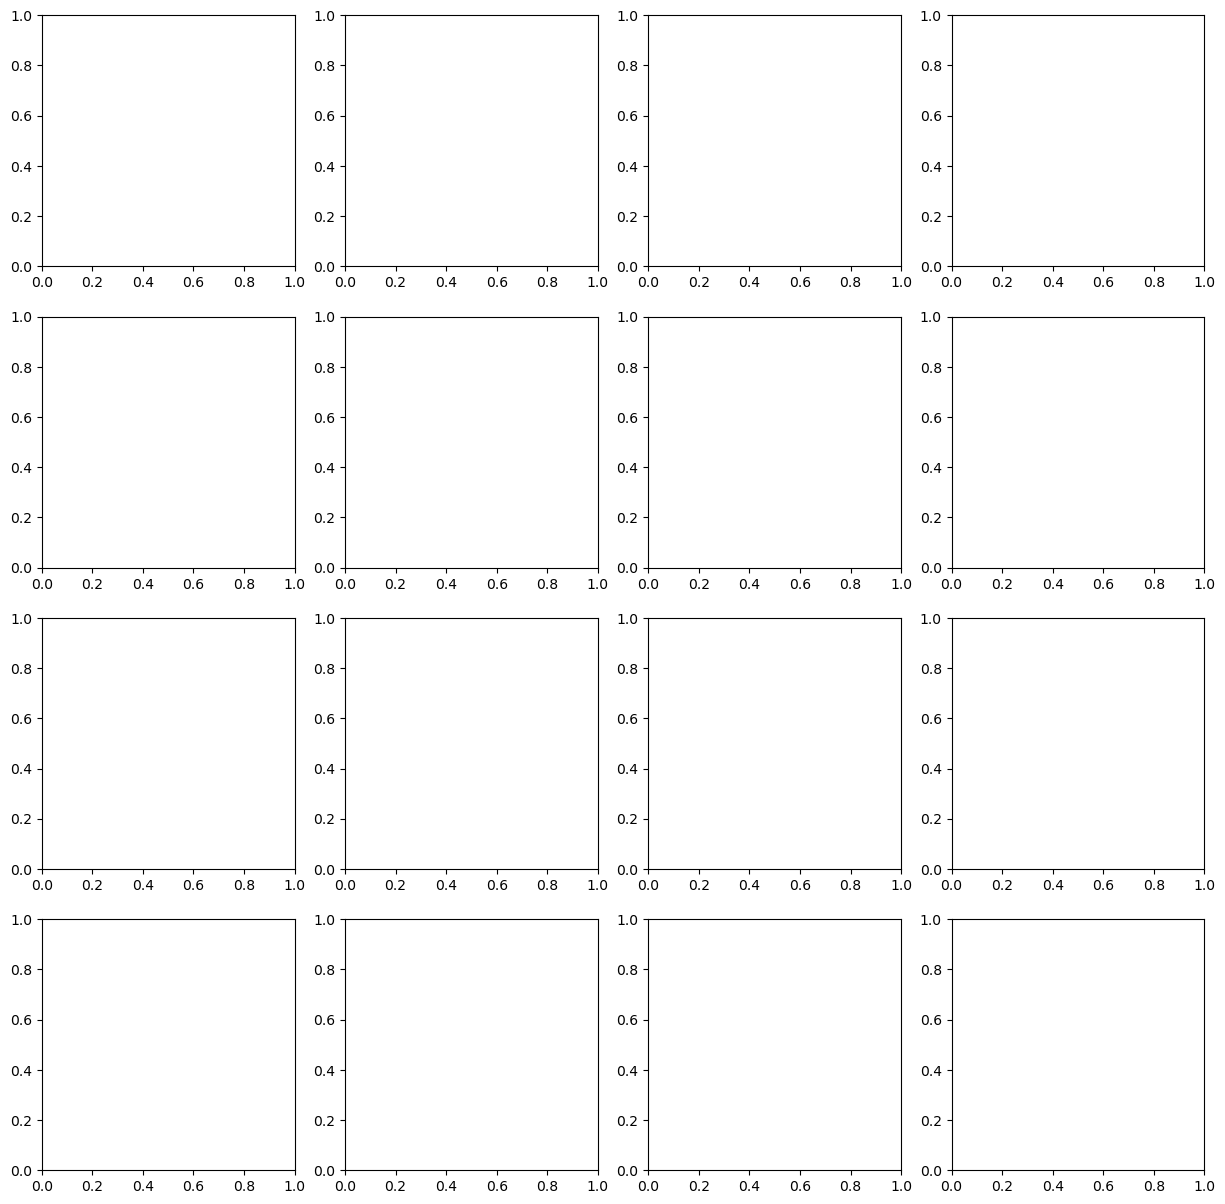

In [82]:
fig, axis = plt.subplots(4, 4, figsize = (15, 15))
init_index = 192
for i in range(2):
    axis[2*i,0].imshow(dataset_train[init_index+i][0][0], cmap = "gray")
    axis[2*i,0].set_title(f"Nebulae {init_index+i}")
    
    axis[2*i,1].imshow(dataset_train[init_index+i+1][0][0], cmap = "gray")
    axis[2*i,1].set_title(f"Nebulae {init_index+i+1}")
    
    axis[2*i,2].imshow(dataset_train[init_index+i+2][0][0], cmap = "gray")
    axis[2*i,2].set_title(f"Nebulae {init_index+i+2}")
    
    axis[2*i,3].imshow(dataset_train[init_index+i+3][0][0], cmap = "gray")
    axis[2*i,3].set_title(f"Nebulae {init_index+i+3}")
    
    _ = axis[2*i+1,0].hist(dataset_train[init_index+i][0].flatten(), bins = 100, color = "blue", alpha = 0.5, label = f"Nebulae {init_index+i}")
    _ = axis[2*i+1,1].hist(dataset_train[init_index+i+1][0].flatten(), bins = 100, color = "red", alpha = 0.5, label = f"Nebulae {init_index+i+1}")
    _ = axis[2*i+1,2].hist(dataset_train[init_index+i+2][0].flatten(), bins = 100, color = "blue", alpha = 0.5, label = f"Nebulae {init_index+i+2}")
    _ = axis[2*i+1,3].hist(dataset_train[init_index+i+3][0].flatten(), bins = 100, color = "red", alpha = 0.5, label = f"Nebulae {init_index+i+3}")
    
    init_index += 3

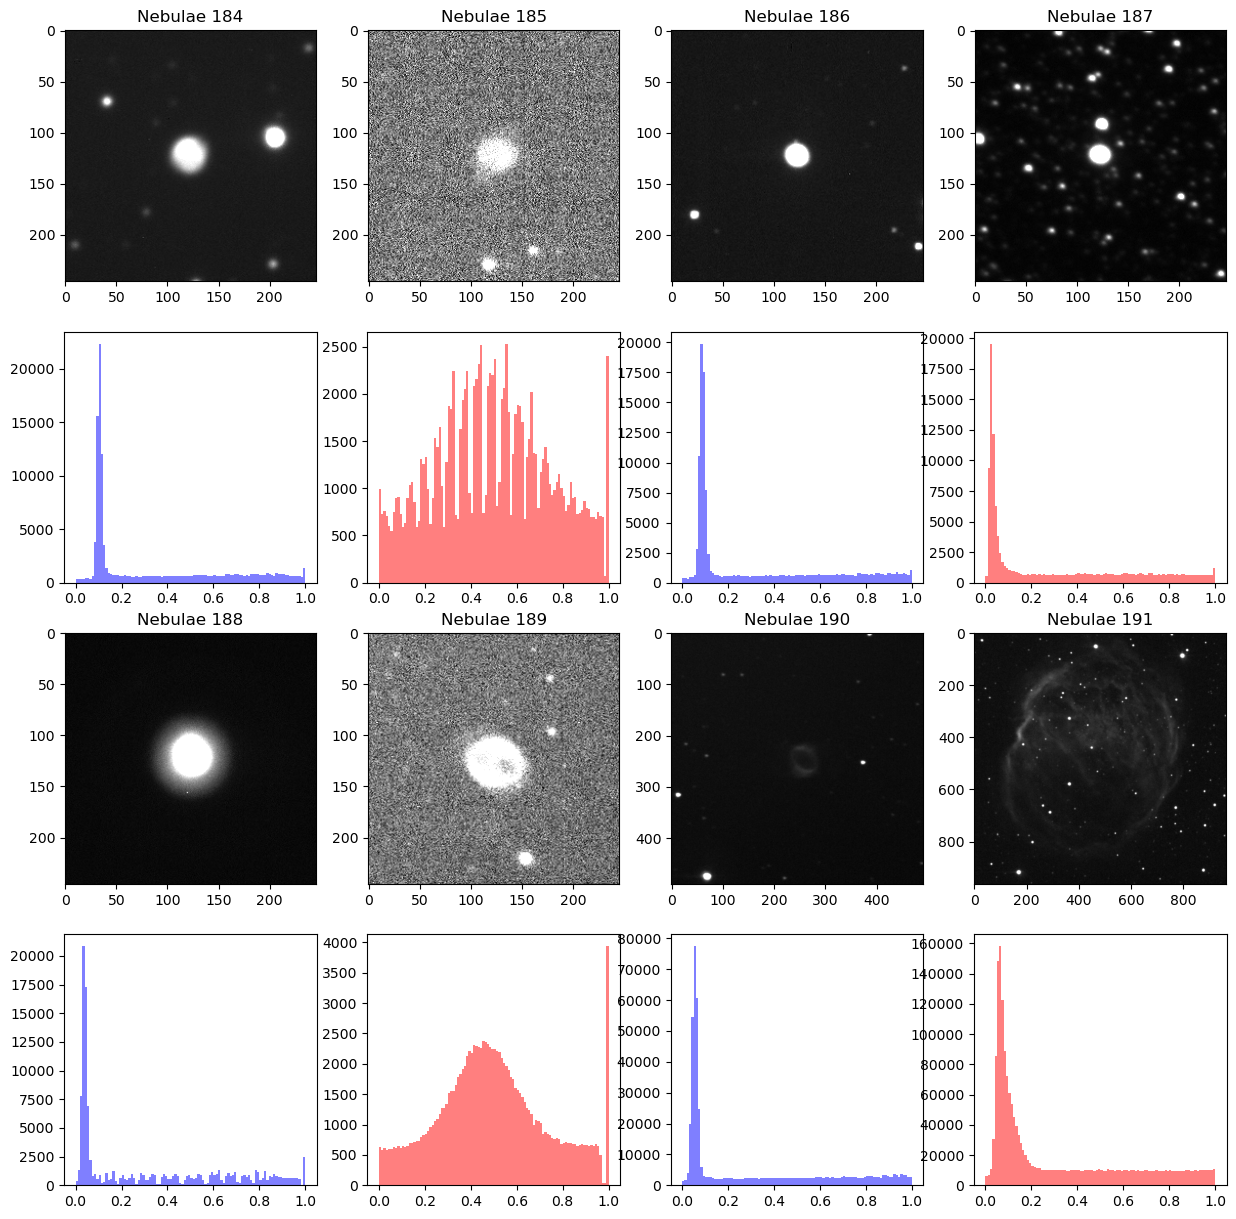

In [81]:
fig, axis = plt.subplots(4, 4, figsize = (15, 15))
init_index = 184
for i in range(2):
    axis[2*i,0].imshow(dataset_train[init_index+i][0][0], cmap = "gray")
    axis[2*i,0].set_title(f"Nebulae {init_index+i}")
    
    axis[2*i,1].imshow(dataset_train[init_index+i+1][0][0], cmap = "gray")
    axis[2*i,1].set_title(f"Nebulae {init_index+i+1}")
    
    axis[2*i,2].imshow(dataset_train[init_index+i+2][0][0], cmap = "gray")
    axis[2*i,2].set_title(f"Nebulae {init_index+i+2}")
    
    axis[2*i,3].imshow(dataset_train[init_index+i+3][0][0], cmap = "gray")
    axis[2*i,3].set_title(f"Nebulae {init_index+i+3}")
    
    _ = axis[2*i+1,0].hist(dataset_train[init_index+i][0].flatten(), bins = 100, color = "blue", alpha = 0.5, label = f"Nebulae {init_index+i}")
    _ = axis[2*i+1,1].hist(dataset_train[init_index+i+1][0].flatten(), bins = 100, color = "red", alpha = 0.5, label = f"Nebulae {init_index+i+1}")
    _ = axis[2*i+1,2].hist(dataset_train[init_index+i+2][0].flatten(), bins = 100, color = "blue", alpha = 0.5, label = f"Nebulae {init_index+i+2}")
    _ = axis[2*i+1,3].hist(dataset_train[init_index+i+3][0].flatten(), bins = 100, color = "red", alpha = 0.5, label = f"Nebulae {init_index+i+3}")
    
    init_index += 3

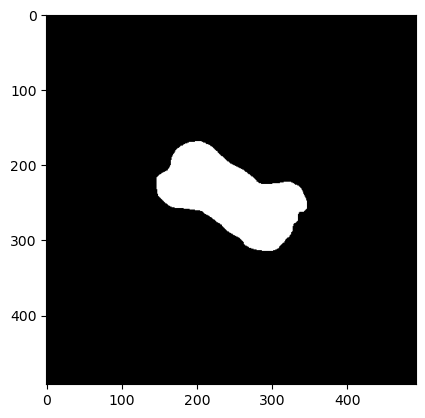

In [76]:
plt.imshow(dataset_train[143][1][0], cmap = "gray")

In [ ]:
nebulae_stats_df = pd.DataFrame(nebulae_stats, columns = ["mean", "std", "min", "max"])
background_stats_df = pd.DataFrame(background_stats, columns = ["mean", "std", "min", "max"])

In [ ]:
nebulae_stats_df.describe().iloc[1]

In [ ]:
background_stats_df.describe().iloc[1]

## Pruebas de Data Augmentation

In [148]:
import numpy as np
transform_x = transforms.Compose([

                        CutValues(factor = 2),
                        TypicalImageNorm(factor = 1, substract=0),

                        ApplyIntensityTransformation(transformation = exposure.equalize_hist, concat = True, nbins = 256),
                        transforms.ToTensor(),
                        ])

transform_y = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Lambda(lambda x: torch.Tensor.int(x.round())),
                    ])

transform_x_aug = transforms.Compose([
                    CutValues(factor = 2),
                    TypicalImageNorm(factor = 1, substract=0),
                    
                    transforms.ToPILImage(),
                    
                    transforms.RandomHorizontalFlip(),  # Voltear la imagen horizontalmente con una probabilidad del 50%
                    transforms.RandomVerticalFlip(),
                    transforms.RandomRotation(180),  # Rotar la imagen aleatoriamente en un rango de -20 a 20 grados
                    transforms.RandomAffine(degrees=0, translate=(0.15, 0.15), scale=(0.75, 1.5)),  # Traslación aleatoria del 10%
                    
                    # transforms.ColorJitter(brightness = (0.75, 1.25), contrast = (0.75, 1.25)),  # Cambios aleatorios en la saturación, brillo y contraste
                    # transforms.RandomInvert(p = 0.5),  # Invertir los colores de la imagen con una probabilidad del 50%
                    transforms.Lambda(lambda x: np.array(x)),
                    
                    ApplyIntensityTransformation(transformation = exposure.equalize_hist, concat = True, nbins = 256),
                    transforms.ToTensor(),
                    ])

transform_y_aug = transforms.Compose([
                    transforms.ToPILImage(),
                    transforms.RandomHorizontalFlip(),  # Voltear la imagen horizontalmente con una probabilidad del 50%
                    transforms.RandomVerticalFlip(),
                    transforms.RandomRotation(180),  # Rotar la imagen aleatoriamente en un rango de -20 a 20 grados
                    transforms.RandomAffine(degrees=0, translate=(0.15, 0.15), scale=(0.75, 1.5)),  # Traslación aleatoria del 10%
                    
                    transforms.ToTensor(),
                    transforms.Lambda(lambda x: torch.Tensor.int(x.round())),
                    ])

df_train = pd.read_csv("data_files_1c_train.csv")
dataset_train = NebulaeDataset(data_directory, masks_directory, df_train, transform = (transform_x, transform_y))

df_train_aug = pd.read_csv("data_files_1c_train_da.csv")
dataset_train_aug = NebulaeDataset(data_directory, masks_directory, df_train_aug, transform = (transform_x_aug, transform_y_aug))

train_subset = torch.utils.data.Subset(dataset_train, list(range(len(dataset_train))))
train_subset_aug = torch.utils.data.Subset(dataset_train_aug, list(range(len(dataset_train))))
train_subset = torch.utils.data.ConcatDataset([train_subset, train_subset_aug])

print(len(dataset_train))

192


In [172]:
df_train['name'].isin(df_train_aug['name'])

0       True
1      False
2       True
3      False
4      False
       ...  
187    False
188    False
189    False
190    False
191     True
Name: name, Length: 192, dtype: bool

In [191]:
indices = list(df_train[df_train['name'].isin(df_train_aug['name'])].dropna().index)


In [192]:
indices = list(df_train[df_train['name'].isin(df_train_aug['name'])].dropna().index)

for i in [0,1,2,3,4]:
    indices.remove(i) if i in indices else None

In [193]:
indices

[5,
 7,
 8,
 35,
 58,
 99,
 108,
 114,
 130,
 138,
 143,
 152,
 156,
 158,
 159,
 182,
 183,
 191]

In [178]:
indices

Index([  0,   2,   5,   7,   8,  35,  58,  99, 108, 114, 130, 138, 143, 152,
       156, 158, 159, 182, 183, 191],
      dtype='int64')

Text(0.5, 1.0, 'Augmented in original mask')

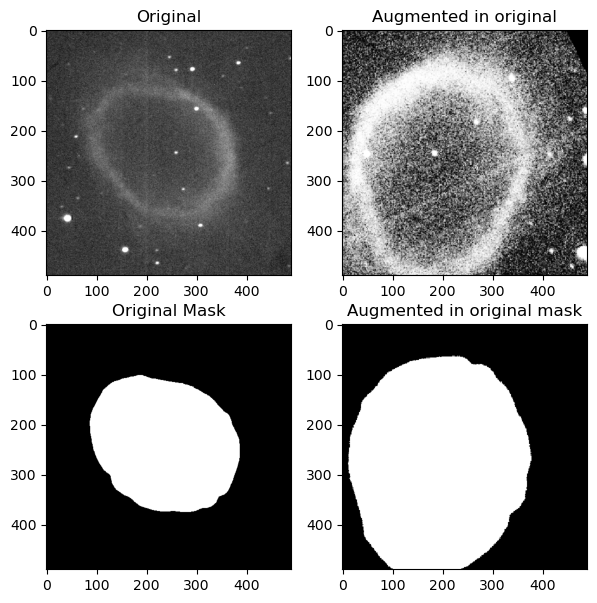

In [147]:
import matplotlib.pyplot as plt
index = 0
image, mask = dataset_train[index]
image_aug, mask_aug = dataset_train_aug[index]
fig, axis = plt.subplots(2, 2, figsize = (7, 7))
axis[0, 0].imshow(image[0], cmap = "gray")
axis[0, 0].set_title("Original")
axis[0, 1].imshow(image_aug[1], cmap = "gray")
axis[0, 1].set_title("Augmented in original")
axis[1, 0].imshow(mask[0], cmap = "gray")
axis[1, 0].set_title("Original Mask")
axis[1, 1].imshow(mask_aug[0], cmap = "gray")
axis[1, 1].set_title("Augmented in original mask")